# **OPTIMISATION SOUS CONTRAINTES EN CHANCES RARES :** #

## Un Cadre Robuste pour la Gestion du Risque de Queue des Actions Piliers de l’Intelligence Artificielle ##

### Author: Georges Marc-Arthur Sébastien ###

In [1]:
# ==============================================================================
# 1. ACTIVATION ET GESTION DES DÉPENDANCES
# ==============================================================================
import Pkg
Pkg.activate(".")    # Active l'environnement local du dossier
Pkg.instantiate()   # Installe les versions exactes du Manifest.toml
#Pkg.add(["CSV", "DataFrames", "Dates", "Statistics", "LinearAlgebra", "Random", 
        #"Plots", "YFinance", "Distributions", "CovarianceEstimation","Ipopt"])

  Activating project at `C:\Users\Admin`


In [2]:
# ==============================================================================
# 2. IMPORTS ET CONFIGURATION
# ==============================================================================
using Pkg
Pkg.precompile()  # Accélère le chargement initial

using CSV, DataFrames, Dates, Statistics, LinearAlgebra, Random
using Plots, YFinance, Distributions, CovarianceEstimation
using JuMP, Ipopt

Random.seed!(1234) # Reproductibilité des simulations

TaskLocalRNG()

In [3]:
# ==============================================================================
# 3. COLLECTE DES DONNÉES 
# ==============================================================================

# Téléchargement avec gestion des tentatives (Retries)
function safe_get_prices(ticker::String; startdt::Date, enddt::Date, max_tries::Int=6)
    for k in 1:max_tries
        try
            df = get_prices(ticker; startdt=startdt, enddt=enddt) |> DataFrame
            return df
        catch e
            wait = 0.8 * k
            @warn "Échec $ticker (tentative $k/$max_tries). Pause $wait sec" exception=e
            sleep(wait)
        end
    end
    @warn "Ticker $ticker abandonné après $max_tries essais."
    return DataFrame()
end

# Nettoyage unitaire par ticker
function fetch_adjclose(ticker::String, startdt::Date, enddt::Date)
    df = safe_get_prices(ticker; startdt=startdt, enddt=enddt)
    if nrow(df) == 0
        return DataFrame(Date=Date[], Symbol(ticker)=>Float64[])
    end
    rename!(df, Symbol("adjclose") => :AdjClose, Symbol("timestamp") => :Date)
    df.Date = Date.(df.Date)
    df = sort(df, :Date)
    select!(df, :Date, :AdjClose)
    rename!(df, :AdjClose => Symbol(ticker))
    return df
end

# Construction du panel global
function build_prices_panel(tickers::Vector{String}; startdt::Date, enddt::Date)
    prices = fetch_adjclose(tickers[1], startdt, enddt)
    for t in tickers[2:end]
        prices = outerjoin(prices, fetch_adjclose(t, startdt, enddt), on=:Date)
    end
    sort!(prices, :Date)
    return prices
end

build_prices_panel (generic function with 1 method)

In [4]:
# ==============================================================================
# 4. TRANSFORMATION ET NETTOYAGE FINANCIER
# ==============================================================================

# Conversion en données hebdomadaires (Fin de semaine)
function to_weekly_last(prices::DataFrame)
    tmp = copy(prices)
    tmp.week = Dates.week.(tmp.Date)
    tmp.year = Dates.year.(tmp.Date)
    g = groupby(tmp, [:year, :week])
    wk = combine(g) do sdf
        sdf[end, :]   
    end
    select!(wk, Not([:year, :week]))
    sort!(wk, :Date)
    return wk
end

# Calcul des log-rendements hebdomadaires
function weekly_log_returns(prices_w::DataFrame, tickers::Vector{String})
    R = DataFrame(Date = prices_w.Date[2:end])
    for t in tickers
        p = prices_w[!, Symbol(t)]
        r = log.(p[2:end]) .- log.(p[1:end-1])
        R[!, Symbol(t)] = r
    end
    dropmissing!(R)
    return R
end

# Filtrage des actifs ayant trop de données manquantes
function filter_by_nonmissing(rets::DataFrame; min_frac::Float64=0.95)
    N = nrow(rets)
    keep = String[]
    for c in names(rets)
        c == "Date" && continue
        frac = count(!ismissing, rets[!, c]) / N
        if frac >= min_frac
            push!(keep, c)
        end
    end
    rets2 = select(rets, ["Date"; keep])
    dropmissing!(rets2)
    return rets2, keep
end

filter_by_nonmissing (generic function with 1 method)

In [5]:
# ==============================================================================
# 5. PARAMÈTRES ET ACQUISITION
# ==============================================================================

# Définition des univers (Satellite IA et Core Protection)
tickers_ia    = ["NVDA", "AMD", "TSM", "ASML", "SMCI", "DELL", "AMZN","GOOGL", "EQIX","ANET", "MSFT","ORCL"]
tickers_core5 = ["VFV.TO", "XEF.TO", "VEE.TO", "PG", "XTLT.TO", "GC=F", "ZMMK.TO"]

startdt = Date(2018, 1, 1)
enddt   = Date(2024, 12, 31)

# Téléchargement des prix quotidiens (Panel séparé pour la modularité)
@info "Téléchargement des données Yahoo Finance..."
prices_ia_daily   = build_prices_panel(tickers_ia; startdt=startdt, enddt=enddt)
prices_core_daily = build_prices_panel(tickers_core5; startdt=startdt, enddt=enddt)

# ==============================================================================
# 6. TRAITEMENT ET FILTRAGE
# ==============================================================================

# Passage au format hebdomadaire (Réduction du bruit)
prices_ia_w   = to_weekly_last(prices_ia_daily)
prices_core_w = to_weekly_last(prices_core_daily)

# Fusion des univers sur la colonne Date
prices_all_w = innerjoin(prices_ia_w, prices_core_w, on=:Date)
dropmissing!(prices_all_w) # Assure une base de calcul saine

tickers_all = vcat(tickers_ia, tickers_core5)

# Calcul des log-rendements hebdomadaires
rets_all = weekly_log_returns(prices_all_w, tickers_all)

# Filtrage final (élimine les actifs avec trop de trous historiques)
rets_all, tickers_all = filter_by_nonmissing(rets_all; min_frac=0.95)

# ==============================================================================
# 7. VÉRIFICATION FINALE
# ==============================================================================
@info "Univers final prêt" tickers_all
display(first(rets_all, 3))
display(last(rets_all, 3))

[ Info: Téléchargement des données Yahoo Finance...
┌ Info: Univers final prêt
│   tickers_all =
│    19-element Vector{String}:
│     "NVDA"
│     "AMD"
│     "TSM"
│     "ASML"
│     "SMCI"
│     ⋮
│     "VEE.TO"
│     "PG"
│     "XTLT.TO"
│     "GC=F"
└     "ZMMK.TO"


Row,Date,NVDA,AMD,TSM,ASML,SMCI,DELL,AMZN,GOOGL,EQIX,ANET,MSFT,ORCL,VFV.TO,XEF.TO,VEE.TO,PG,XTLT.TO,GC=F,ZMMK.TO
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2023-02-24,0.0850223,-0.00523666,-0.0223343,-0.052834,0.0650276,-0.0206928,-0.0388092,-0.0569153,-0.0456142,-0.0197259,-0.034856,0.0156875,-0.0169409,-0.0175763,-0.0220866,-0.00537142,0.0143847,-0.0173193,0.00060006
2,2023-03-03,0.0256075,0.0429864,0.0188877,0.030263,-0.00336752,-0.0447251,0.0148623,0.0494686,0.0296522,0.0372947,0.0240641,0.00663275,0.0179646,0.0244615,0.0311475,0.0120627,-0.0232206,0.0212779,0.0010011
3,2023-03-10,-0.0393189,0.0140084,-0.0286961,-0.0584219,-0.0532158,-0.0802941,-0.0449356,-0.0327792,-0.0531994,0.0402646,-0.0265952,-0.0597915,-0.0273848,-0.0138182,-0.0221926,-0.0270383,0.0746671,0.00770958,0.0005997


Row,Date,NVDA,AMD,TSM,ASML,SMCI,DELL,AMZN,GOOGL,EQIX,ANET,MSFT,ORCL,VFV.TO,XEF.TO,VEE.TO,PG,XTLT.TO,GC=F,ZMMK.TO
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2024-12-20,0.00334633,-0.0625916,-0.018986,-0.0181152,-0.143101,-0.0228855,-0.0112297,0.00834149,-0.0399373,0.00390794,-0.0241449,-0.0217469,-0.00964543,-0.0244485,-0.0147099,-0.0176933,-0.0082236,-0.0103318,0.00059973
2,2024-12-27,0.0170039,0.048946,0.0221652,0.0111467,0.0122701,0.013385,-0.00521542,0.00702805,0.0165149,0.00194829,-0.0140005,-0.0041344,0.00905748,0.0156744,0.00535087,0.00870883,-0.00995854,-0.00438438,0.000599371
3,2024-12-30,0.0034972,-0.0222115,-0.006169,-0.0247435,-0.0414997,-0.0216248,-0.0110101,-0.00791654,-0.00716496,-0.0140772,-0.013328,-0.0122073,-0.0151816,-0.0109306,-0.0127687,-0.0144974,-0.00772051,-0.00425014,0.000400848


In [6]:
# =========================================================
# 8. PARAMETER ESTIMATION (RISK & RETURN) -- PATCHED
# =========================================================

using Statistics, DataFrames
# (Assume CovarianceEstimation is already imported in your notebook)
# using CovarianceEstimation  # if not already loaded

# --- 0) Define the two universes (must match your earlier tickers lists) ---
tickers_sat = tickers_ia          # 12 AI ecosystem names
tickers_core = tickers_core5      # 7 core assets
tickers_all = vcat(tickers_sat, tickers_core)

# --- 1) Build the joint return matrix X (ALL assets) ---
X = Matrix(select(rets_all, tickers_all))   # Dimensions: T × d_all

# --- 2) Mean vector ---
μ = vec(mean(X, dims=1))                   # weekly mean return per asset

# --- 3) Covariance matrix (Ledoit–Wolf linear shrinkage) ---
Σ_emp = cov(X)

Σ_sh = cov(LinearShrinkage(DiagonalCommonVariance()), X)
Σ_sh = Symmetric(Matrix(Σ_sh))             # ensure symmetry for solvers

# --- 4) Individual risk (weekly std) ---
σ = vec(std(X, dims=1))

# --- 5) Split μ and Σ into Core/Satellite blocks (for λ integration) ---
dS = length(tickers_sat)
dC = length(tickers_core)

μS = μ[1:dS]
μC = μ[dS+1:end]

ΣSS = Matrix(Σ_sh[1:dS, 1:dS])
ΣCC = Matrix(Σ_sh[dS+1:end, dS+1:end])
ΣCS = Matrix(Σ_sh[dS+1:end, 1:dS])   # Core rows × Satellite cols

# Optional: keep full Σ for aggregated portfolio computations
Σ_all = Matrix(Σ_sh)

@info "Joint μ and Ledoit–Wolf Σ estimated on Core + Satellite."

[ Info: Joint μ and Ledoit–Wolf Σ estimated on Core + Satellite.


In [7]:
@info "len(tickers_ia) = $(length(tickers_ia))"
@info "len(tickers_core5) = $(length(tickers_core5))"

@info "tickers_ia = $(tickers_ia)"
@info "tickers_core5 = $(tickers_core5)"

@info "Columns missing from rets_all (IA) = $(setdiff(tickers_ia, names(rets_all)))"
@info "Columns missing from rets_all (Core) = $(setdiff(tickers_core5, names(rets_all)))"

@info "Selected tickers_all length = $(length(vcat(tickers_ia, tickers_core5)))"


[ Info: len(tickers_ia) = 12
[ Info: len(tickers_core5) = 7
[ Info: tickers_ia = ["NVDA", "AMD", "TSM", "ASML", "SMCI", "DELL", "AMZN", "GOOGL", "EQIX", "ANET", "MSFT", "ORCL"]
[ Info: tickers_core5 = ["VFV.TO", "XEF.TO", "VEE.TO", "PG", "XTLT.TO", "GC=F", "ZMMK.TO"]
[ Info: Columns missing from rets_all (IA) = String[]
[ Info: Columns missing from rets_all (Core) = String[]
[ Info: Selected tickers_all length = 19


In [8]:
# =========================================================
# 9. DESCRIPTIVE STATISTICS SUMMARY (ANNUALIZED) -- PATCHED
# =========================================================

# Helper to build summary table
function build_summary(tickers::Vector{String}, μ::Vector, σ::Vector; label::String)
    df = DataFrame(
        group = fill(label, length(tickers)),
        ticker = tickers,
        mu_week = μ,
        sigma_week = σ,
        mu_ann_approx = 52 .* μ,
        sigma_ann_approx = sqrt(52) .* σ
    )
    return df
end

# Indices for slicing
idx_sat  = 1:dS
idx_core = (dS+1):(dS+dC)

summary_sat = build_summary(tickers_sat, μ[idx_sat], σ[idx_sat]; label="AI Satellite")
summary_core = build_summary(tickers_core, μ[idx_core], σ[idx_core]; label="Core")

# (Optional) combined view
summary_all = vcat(summary_sat, summary_core)

@info "Descriptive statistics tables created: summary_sat, summary_core, summary_all."
display(summary_sat)
display(summary_core)


[ Info: Descriptive statistics tables created: summary_sat, summary_core, summary_all.


Row,group,ticker,mu_week,sigma_week,mu_ann_approx,sigma_ann_approx
,String,String,Float64,Float64,Float64,Float64
1,AI Satellite,NVDA,0.0191902,0.0634627,0.99789,0.457636
2,AI Satellite,AMD,0.00458271,0.064488,0.238301,0.46503
3,AI Satellite,TSM,0.00858405,0.0498369,0.44637,0.359379
4,AI Satellite,ASML,0.00083845,0.0526628,0.0435994,0.379757
5,AI Satellite,SMCI,0.0124188,0.150428,0.645778,1.08475
6,AI Satellite,DELL,0.0106275,0.0691907,0.552627,0.498941
7,AI Satellite,AMZN,0.00848194,0.0338425,0.441061,0.244042
8,AI Satellite,GOOGL,0.007321,0.0400839,0.380692,0.289049
9,AI Satellite,EQIX,0.0031613,0.0319326,0.164388,0.230269


Row,group,ticker,mu_week,sigma_week,mu_ann_approx,sigma_ann_approx
,String,String,Float64,Float64,Float64,Float64
1,Core,VFV.TO,0.00469662,0.0154612,0.244224,0.111492
2,Core,XEF.TO,0.00187768,0.0159172,0.0976393,0.114781
3,Core,VEE.TO,0.00204387,0.0172321,0.106281,0.124263
4,Core,PG,0.00227034,0.0188801,0.118058,0.136146
5,Core,XTLT.TO,-0.000204253,0.0219456,-0.0106212,0.158252
6,Core,GC=F,0.00358631,0.0194015,0.186488,0.139906
7,Core,ZMMK.TO,0.000914523,0.000303041,0.0475552,0.00218526


In [12]:
# ==============================================================================
# 13. OPTIMAL CORE–SATELLITE ALLOCATION UNDER RARE CHANCE CONSTRAINTS (FULL BLOCK)
#    UPDATED: λ integrated + bounded optimization (maximize mean, fixed loss L)
# ==============================================================================

using DataFrames
using Random
using LinearAlgebra
using Statistics
using Distributions
using JuMP
using Ipopt
using OSQP   # Pkg.add("OSQP")

# ------------------------------------------------------------------------------
# (A) Rare-event / FORM utilities
# ------------------------------------------------------------------------------

"""
dominant_point_gaussian(u, z, μ, Σ)

Event: loss = -u'ξ ≥ z  ⇔  u'ξ ≤ -z.
Dominant point on boundary u'ξ = -z for Gaussian reference.

Returns: ξ_star, t, I, λ
- t = (z + u'μ)/sqrt(u'Σu)  (tail index, should be > 0 in rare regime)
- I = 0.5*t^2               (rate)
- ξ_star = μ - λ Σ u
- λ = (u'μ + z)/(u'Σu)
"""
function dominant_point_gaussian(u::AbstractVector, z::Real, μ::AbstractVector, Σ::AbstractMatrix)
    s2 = dot(u, Σ*u)
    @assert s2 > 0 "u'Σu must be positive."

    m  = dot(u, μ)
    λ  = (m + z) / s2
    ξs = μ .- λ .* (Σ*u)

    t  = (z + m) / sqrt(s2)
    I  = 0.5 * t^2
    return ξs, t, I, λ
end

"""
P1_first_order(u, z, μ, Σ)

First-order rare-event approximation for P(loss ≥ z) = P(u'ξ ≤ -z).
For large t>0: Φ(-t) ~ ϕ(t)/t (Mills ratio).

We use:
P1 = exp(-0.5*t^2) / (sqrt(2π)*t)

Returns: P1, logP1, t, I
"""
function P1_first_order(u::AbstractVector, z::Real, μ::AbstractVector, Σ::AbstractMatrix; ϵ::Real=1e-12)
    _, t, I, _ = dominant_point_gaussian(u, z, μ, Σ)
    t_eff = max(t, ϵ)
    logP1 = -0.5*t_eff^2 - 0.5*log(2π) - log(t_eff)
    P1    = exp(logP1)
    return P1, logP1, t, I
end

"""
mc_prob_and_var_cvar_loss(u, z, μ, Σ; N=200_000, alpha=0.01, seed=1234)

Simule ξ ~ N(μ,Σ), calcule les pertes L = -u'ξ.
Retourne :
- mc       = P̂(L ≥ z)
- hits     = nombre de dépassements
- lo, hi   = IC binomial (Wilson) pour P(L ≥ z)
- VaR_MC   = quantile empirique de L au niveau 1-alpha (VaR_{1-alpha})
- CVaR_MC  = moyenne des pertes au-delà de VaR_MC (ES_{1-alpha})
"""
function mc_prob_and_var_cvar_loss(u::Vector{Float64}, z::Float64,
                                   μ::Vector{Float64}, Σ::AbstractMatrix;
                                   N::Int=200_000, alpha::Real=0.01, seed::Int=1234)

    Random.seed!(seed)

    Σmat = Matrix(Σ)
    mv = MvNormal(μ, Σmat)

    # Tirages : d × N
    X = rand(mv, N)

    # Pertes : L = -u'ξ
    losses = -vec(u' * X)

    hits = count(>=(z), losses)
    mc = hits / N

    # IC Wilson (95%)
    zcrit = quantile(Normal(), 0.975)
    phat = mc
    denom = 1 + zcrit^2 / N
    center = (phat + zcrit^2/(2N)) / denom
    half = (zcrit * sqrt(phat*(1-phat)/N + zcrit^2/(4N^2))) / denom
    lo = max(0.0, center - half)
    hi = min(1.0, center + half)

    # VaR / CVaR (right tail of losses)
    VaR_MC = quantile(losses, 1 - alpha)

    k = max(1, ceil(Int, float(alpha) * N))
    Ls = sort(losses)
    idx = N - k + 1
    CVaR_MC = mean(@view Ls[idx:N])

    return mc, hits, lo, hi, VaR_MC, CVaR_MC
end

"""
build_table_52(portfolios, μ, Σ; ...)

For a set of fixed portfolios u (each sums to 1), computes:
- z* by inverting P1(u,z*) = alpha
- FORM metrics at z*
- Monte Carlo probability and VaR/CVaR

Returns a DataFrame.
"""
function build_table_52(portfolios::Dict{String,Vector{Float64}},
                        μ::Vector{Float64}, Σ::AbstractMatrix;
                        alpha::Real=0.01,
                        Nmc::Int=200_000,
                        seed::Int=1234,
                        z_hi::Float64=0.30,
                        bisect_iters::Int=80,
                        tol_sum::Float64=1e-8,
                        tol_long::Float64=1e-12)

    Σmat = Matrix(Σ)

    rows = DataFrame(
        method   = String[],
        z_star   = Float64[],
        P1       = Float64[],
        MC       = Float64[],
        hits     = Int[],
        MC_lo    = Float64[],
        MC_hi    = Float64[],
        VaR_MC   = Float64[],
        CVaR_MC  = Float64[],
        Delta    = Float64[],
        t        = Float64[],
        I        = Float64[],
        time_sec = Float64[]
    )

    function _check_u(name::String, u::Vector{Float64})
        s = sum(u)
        if abs(s - 1.0) > tol_sum
            @warn "Weights do not sum to 1; normalizing" method=name sum=s
            u = u ./ s
        end
        if minimum(u) < -tol_long
            @warn "Found negative weights (not long-only)" method=name min_u=minimum(u)
        end
        return u
    end

    function _solve_z_star(u, μ, Σmat; alpha, z_lo=0.0, z_hi=z_hi, iters=bisect_iters)
        P1_lo, _, _, _ = P1_first_order(u, z_lo, μ, Σmat)
        if P1_lo < alpha
            @warn "alpha too large or z_lo too high; returning z_lo" P1_lo alpha
            return z_lo
        end

        zH = z_hi
        P1_hi, _, _, _ = P1_first_order(u, zH, μ, Σmat)
        expand = 0
        while P1_hi > alpha && expand < 30
            zH *= 1.5
            P1_hi, _, _, _ = P1_first_order(u, zH, μ, Σmat)
            expand += 1
        end
        if P1_hi > alpha
            @warn "Could not bracket root; alpha may be too small for current z range" alpha zH P1_hi
            return zH
        end

        zL = z_lo
        for _ in 1:iters
            zM = 0.5*(zL + zH)
            P1_mid, _, _, _ = P1_first_order(u, zM, μ, Σmat)
            if P1_mid > alpha
                zL = zM
            else
                zH = zM
            end
        end
        return zH
    end

    for name in sort(collect(keys(portfolios)))
        u0 = portfolios[name]
        t_start = time_ns()

        u = _check_u(name, copy(u0))

        # 1) z* via inversion P1(u,z*) = alpha
        z_star = _solve_z_star(u, μ, Σmat; alpha=alpha)

        # 2) FORM metrics at z*
        P1, _, tval, Ival = P1_first_order(u, z_star, μ, Σmat)

        # 3) MC at z* + VaR/CVaR
        seed_i = seed + Int(mod(hash(name), 1_000_000))
        mc, hits, lo, hi, var_mc, cvar_mc = mc_prob_and_var_cvar_loss(u, z_star, μ, Σmat;
                                                        N=Nmc, alpha=alpha, seed=seed_i)

        Δ = var_mc - z_star
        time_sec = (time_ns() - t_start) / 1e9

        push!(rows, (name, z_star, P1, mc, hits, lo, hi, var_mc, cvar_mc, Δ, tval, Ival, time_sec))
    end

    return rows
end

# ------------------------------------------------------------------------------
# (B) Basic portfolio constructors (unchanged)
# ------------------------------------------------------------------------------

"Equal-weight portfolio"
w_equal(d::Int) = fill(1.0/d, d)

"Max-return portfolio: max u'μ s.t. sum(u)=1, u>=0"
function w_max_return(μ::AbstractVector)
    d = length(μ)
    m = Model(OSQP.Optimizer)
    set_silent(m)

    @variable(m, u[1:d] >= 0)
    @constraint(m, sum(u) == 1)
    @objective(m, Max, sum(μ[i] * u[i] for i in 1:d))
    optimize!(m)

    return value.(u)
end

"Min-variance portfolio: min u'Σu s.t. sum(u)=1, u>=0"
function w_min_variance(Σ::AbstractMatrix)
    d = size(Σ, 1)
    m = Model(OSQP.Optimizer)
    set_silent(m)

    @variable(m, u[1:d] >= 0)
    @constraint(m, sum(u) == 1)

    @objective(m, Min, u' * Σ * u)
    set_optimizer_attribute(m, "eps_abs", 1e-9)
    set_optimizer_attribute(m, "eps_rel", 1e-9)
    optimize!(m)

    return value.(u)
end

"""
sanitize_weights(u; tol_neg=1e-10)
- clamps tiny negatives, renormalizes to sum=1
"""
function sanitize_weights(u::AbstractVector; tol_neg::Float64=1e-10)
    u2 = copy(u)
    for i in eachindex(u2)
        if u2[i] < 0 && u2[i] > -tol_neg
            u2[i] = 0.0
        end
    end
    if minimum(u2) < 0
        @warn "Negative weight beyond tolerance" min_u=minimum(u2)
        u2 .= max.(u2, 0.0)
    end
    s = sum(u2)
    if s == 0
        error("All weights are zero after sanitization.")
    end
    return u2 ./ s
end

# ------------------------------------------------------------------------------
# (C) Core–Satellite helpers with λ (NEW)
# ------------------------------------------------------------------------------

"Aggregate weights w(λ) = (1-λ) wC + λ wS, each input normalized to sum=1."
function aggregate_weights(wC::AbstractVector, wS::AbstractVector, λ::Real)
    @assert 0.0 <= λ <= 1.0 "λ must be in [0,1]"
    wC2 = wC ./ sum(wC)
    wS2 = wS ./ sum(wS)
    return (1 - λ) .* wC2 .+ λ .* wS2
end

"Full joint weight vector consistent with tickers_all order = [satellite; core]."
function full_weights_sat_core(wC::AbstractVector, wS::AbstractVector, λ::Real)
    wC2 = wC ./ sum(wC)
    wS2 = wS ./ sum(wS)
    return vcat(λ .* wS2, (1-λ) .* wC2)
end

# ------------------------------------------------------------------------------
# (D) Core optimization under rare chance constraint at fixed loss threshold L (UPDATED)
# ------------------------------------------------------------------------------

"""
solve_core_satellite_mean_under_chance(...)

For fixed λ and fixed Satellite weights wS, solve:
    max_{wC}   E[R_p(λ)]
s.t. wC>=0, sum(wC)=1,
     P1(loss >= L) <= alpha

where loss is defined on the aggregated portfolio return:
    loss = -R_p(λ)
and the chance constraint is enforced via the first-order Mills approximation.
"""
function solve_core_satellite_mean_under_chance(μC::AbstractVector, μS::AbstractVector,
                                                ΣCC::AbstractMatrix, ΣSS::AbstractMatrix, ΣCS::AbstractMatrix,
                                                wS::AbstractVector;
                                                λ::Real,
                                                alpha::Real=0.01,
                                                L::Real=0.05,
                                                maxiter::Int=4000,
                                                silent::Bool=true)

    dC = length(μC)
    dS = length(μS)
    @assert length(wS) == dS "wS length mismatch."
    @assert 0.0 <= λ <= 1.0 "λ must be in [0,1]."

    wS = wS ./ sum(wS)

    ΣCCm = Matrix(ΣCC)
    ΣSSm = Matrix(ΣSS)
    ΣCSm = Matrix(ΣCS)

    model = Model(Ipopt.Optimizer)
    if silent
        set_silent(model)
    end
    set_optimizer_attribute(model, "max_iter", maxiter)

    @variable(model, wC[1:dC] >= 0.0)
    @constraint(model, sum(wC) == 1.0)

    for i in 1:dC
        set_start_value(wC[i], 1/dC)
    end

    eps = 1e-12

    # Satellite constants
    mS_const  = dot(μS, wS)
    s2S_const = dot(wS, ΣSSm*wS)

    # v = ΣCS * wS so cross = wC' v
    v = ΣCSm * wS

    # Aggregated mean
    @NLexpression(model, mC, sum(μC[i] * wC[i] for i in 1:dC))
    @NLexpression(model, m,  (1-λ)*mC + λ*mS_const)

    # Aggregated variance
    @NLexpression(model, s2C, sum(ΣCCm[i,j] * wC[i] * wC[j] for i in 1:dC, j in 1:dC))
    @NLexpression(model, cross, sum(v[i] * wC[i] for i in 1:dC))
    @NLexpression(model, s2,
        (1-λ)^2 * s2C + (λ^2) * s2S_const + 2*(1-λ)*λ * cross
    )

    # Chance constraint at fixed loss threshold L
    @NLexpression(model, t, (L + m) / sqrt(s2 + eps))
    @NLexpression(model, logP1, -0.5*t^2 - 0.5*log(2π) - log(t + eps))
    @NLconstraint(model, logP1 <= log(alpha))

    # Objective: maximize expected return (aggregated mean)
    @NLobjective(model, Max, m)

    optimize!(model)

    wC_star = sanitize_weights(value.(wC))
    return wC_star, model
end

# ------------------------------------------------------------------------------
# (E) Section 5.2 runner: evaluate P1/MC/VaR/CVaR at fixed L across λ-grid (UPDATED)
# ------------------------------------------------------------------------------

"""
run_lambda_grid_results(...)

For each λ:
- solve for Core weights wC maximizing mean subject to P1(loss>=L) <= alpha
- build full joint weights w_all = [λ*wS; (1-λ)*wC]
- compute FORM P1 at threshold L
- compute MC probability at threshold L + VaR/CVaR (loss distribution)
"""
function run_lambda_grid_results(μ_all::Vector{Float64}, Σ_all::AbstractMatrix,
                                 μC::Vector{Float64}, μS::Vector{Float64},
                                 ΣCC::AbstractMatrix, ΣSS::AbstractMatrix, ΣCS::AbstractMatrix,
                                 wS::Vector{Float64};
                                 lambdas = 0.0:0.05:0.50,
                                 alpha::Real = 0.01,
                                 L::Real = 0.05,
                                 Nmc::Int = 200_000,
                                 seed::Int = 1234)

    rows = DataFrame(
        λ = Float64[],
        L = Float64[],
        P1 = Float64[],
        MC = Float64[],
        hits = Int[],
        MC_lo = Float64[],
        MC_hi = Float64[],
        VaR_MC = Float64[],
        CVaR_MC = Float64[],
        t = Float64[],
        I = Float64[]
    )

    core_weights = Dict{Float64, Vector{Float64}}()
    full_weights = Dict{Float64, Vector{Float64}}()

    for λ in lambdas
        # 1) Optimize Core under chance constraint at L
        wC_star, _ = solve_core_satellite_mean_under_chance(μC, μS, ΣCC, ΣSS, ΣCS, wS;
                                                            λ=λ, alpha=alpha, L=L,
                                                            silent=true)
        core_weights[Float64(λ)] = wC_star

        # 2) Full weights and risk evaluation on joint distribution
        w_all = full_weights_sat_core(wC_star, wS, λ)
        full_weights[Float64(λ)] = w_all

        P1, _, tval, Ival = P1_first_order(w_all, L, μ_all, Σ_all)

        seed_i = seed + Int(mod(hash(λ), 1_000_000))
        mc, hits, lo, hi, var_mc, cvar_mc = mc_prob_and_var_cvar_loss(
            Vector{Float64}(w_all), Float64(L), μ_all, Σ_all;
            N=Nmc, alpha=alpha, seed=seed_i
        )

        push!(rows, (Float64(λ), Float64(L), Float64(P1), Float64(mc), hits,
                     Float64(lo), Float64(hi), Float64(var_mc), Float64(cvar_mc),
                     Float64(tval), Float64(Ival)))
    end

    return rows, core_weights, full_weights
end


run_lambda_grid_results

In [13]:
wS = fill(1/length(tickers_sat), length(tickers_sat))   # equal-weight satellite
lambdas = 0.0:0.05:0.50

tbl52_lambda, core_w_byλ, full_w_byλ = run_lambda_grid_results(
    μ, Σ_all, μC, μS, ΣCC, ΣSS, ΣCS, wS;
    lambdas=lambdas, alpha=0.01, Nmc=200_000, seed=123
)

display(tbl52_lambda)


Row,λ,L,P1,MC,hits,MC_lo,MC_hi,VaR_MC,CVaR_MC,t,I
,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.05,0.00406617,0.00363,726,0.00337579,0.00390327,0.0427416,0.0496501,2.68298,3.59919
2,0.05,0.05,0.00409185,0.003875,775,0.00361208,0.00415698,0.0428264,0.0498842,2.68092,3.59366
3,0.1,0.05,0.0043178,0.003955,791,0.00368929,0.00423976,0.0430402,0.0501759,2.66327,3.54652
4,0.15,0.05,0.00475712,0.004405,881,0.00412413,0.00470491,0.0436277,0.0510025,2.63124,3.46172
5,0.2,0.05,0.0054366,0.00489,978,0.00459365,0.00520537,0.04451,0.0516746,2.58662,3.34531
6,0.25,0.05,0.00639475,0.005765,1153,0.00544256,0.00610643,0.0455787,0.0528834,2.5316,3.20449
7,0.3,0.05,0.00767903,0.007175,1435,0.00681445,0.00755448,0.0470477,0.0549688,2.46849,3.04672
8,0.35,0.05,0.00934241,0.00818,1636,0.00779458,0.00858431,0.048275,0.0559647,2.39957,2.87896
9,0.4,0.05,0.00999992,0.008815,1763,0.00841467,0.0092342,0.0488319,0.056869,2.37533,2.8211


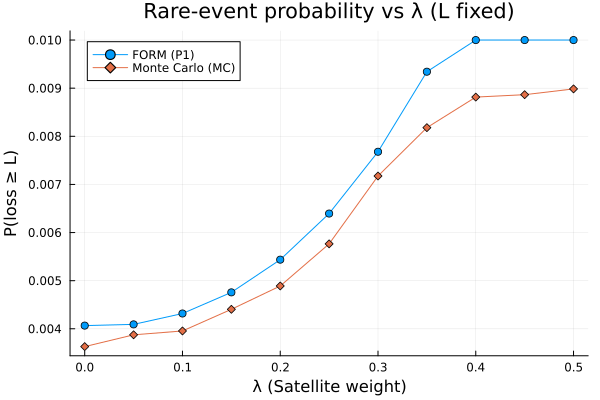

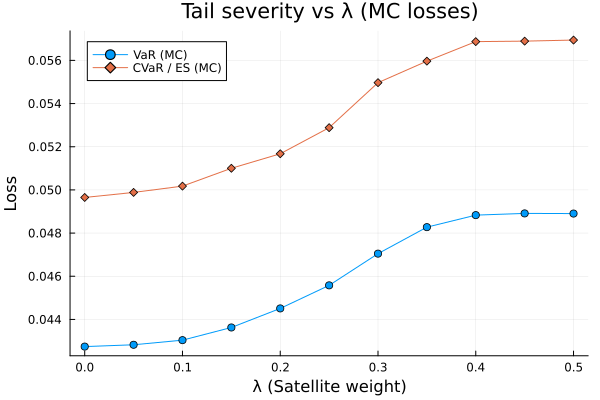

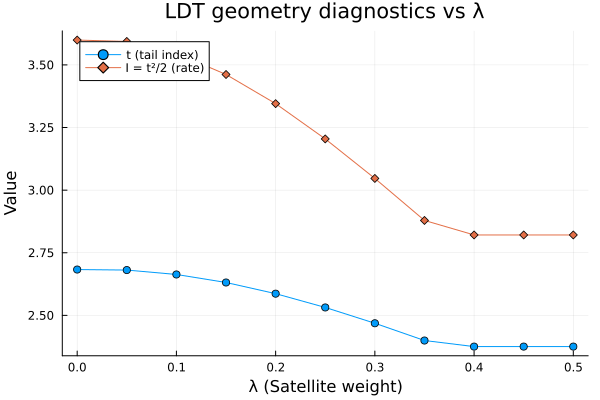

"C:\\Users\\Admin\\lambda_ldt_t_I.png"

In [22]:
using Plots
using DataFrames

# --- Ensure data sorted by λ ---
df = sort(tbl52_lambda, :λ)

λ = df.λ
P1 = df.P1
MC = df.MC
VaR = df.VaR_MC
CVaR = df.CVaR_MC
tval = df.t
Ival = df.I

# =========================================================
# 1) λ vs Probability of extreme loss: FORM (P1) vs MC
# =========================================================
p_prob = plot(
    λ, P1,
    label="FORM (P1)",
    marker=:circle,
    xlabel="λ (Satellite weight)",
    ylabel="P(loss ≥ L)",
    title="Rare-event probability vs λ (L fixed)",
    legend=:topleft
)
plot!(p_prob, λ, MC, label="Monte Carlo (MC)", marker=:diamond)

display(p_prob)

# =========================================================
# 2) λ vs VaR and CVaR (tail severity)
# =========================================================
p_tail = plot(
    λ, VaR,
    label="VaR (MC)",
    marker=:circle,
    xlabel="λ (Satellite weight)",
    ylabel="Loss",
    title="Tail severity vs λ (MC losses)",
    legend=:topleft
)
plot!(p_tail, λ, CVaR, label="CVaR / ES (MC)", marker=:diamond)

display(p_tail)

# =========================================================
# 3) (Optional) λ vs LDT geometry: t and I
# =========================================================
p_ldt = plot(
    λ, tval,
    label="t (tail index)",
    marker=:circle,
    xlabel="λ (Satellite weight)",
    ylabel="Value",
    title="LDT geometry diagnostics vs λ",
    legend=:topleft
)
plot!(p_ldt, λ, Ival, label="I = t²/2 (rate)", marker=:diamond)

display(p_ldt)

# =========================================================
# 4) Save figures (optional)
# =========================================================
 savefig(p_prob, "lambda_prob_FORM_vs_MC.png")
 savefig(p_tail, "lambda_tail_VaR_CVaR.png")
 savefig(p_ldt,  "lambda_ldt_t_I.png")


In [15]:
using DataFrames, Statistics

# Choose a few lambdas to inspect
lams = [0.0, 0.25, 0.5]   # adjust if you prefer

function dominant_point_report(λ, full_w_byλ, μ_all, Σ_all, tickers_all; L=0.05)
    u = full_w_byλ[λ]                 # full weights (satellite; core)
    ξs, t, I, lam_mult = dominant_point_gaussian(u, L, μ_all, Σ_all)

    Δ = ξs .- μ_all                   # shock relative to mean
    # "Contribution" proxy: weight × shock (not unique but interpretable)
    contrib = u .* Δ

    df = DataFrame(
        ticker = tickers_all,
        weight = u,
        mu = μ_all,
        xi_star = ξs,
        delta = Δ,
        contrib = contrib
    )

    # rank by absolute shock and by absolute contribution
    df_absΔ = sort(df, :delta, rev=true, by=x->abs(x))
    df_absC = sort(df, :contrib, rev=true, by=x->abs(x))

    return (λ=λ, t=t, I=I, lam_mult=lam_mult, df=df, top_shock=df_absΔ[1:10, :], top_contrib=df_absC[1:10, :])
end

reports = Dict{Float64, Any}()

for λ in lams
    reports[λ] = dominant_point_report(λ, full_w_byλ, μ, Σ_all, tickers_all; L=0.05)
    @info "Dominant point computed" λ=λ t=reports[λ].t I=reports[λ].I
end

# Display top contributors for each λ
for λ in lams
    println("\n======================")
    println("λ = ", λ, " | t = ", round(reports[λ].t, digits=4), " | I = ", round(reports[λ].I, digits=4))
    println("Top-10 |Δ| (shock magnitude):")
    display(reports[λ].top_shock)
    println("Top-10 |weight×Δ| (weighted contribution):")
    display(reports[λ].top_contrib)
end


┌ Info: Dominant point computed
│   λ = 0.0
│   t = 2.6829791142416943
└   I = 3.599188463728573



λ = 

┌ Info: Dominant point computed
│   λ = 0.25
│   t = 2.5315962899728985
└   I = 3.2044898877022723
┌ Info: Dominant point computed
│   λ = 0.5
│   t = 2.375330862754368
└   I = 2.821098353776705


0.0 | t = 2.683 | I = 3.5992
Top-10 |Δ| (shock magnitude):


Row,ticker,weight,mu,xi_star,delta,contrib
,String,Float64,Float64,Float64,Float64,Float64
1,SMCI,0.0,0.0124188,-0.101013,-0.113432,-0.0
2,NVDA,0.0,0.0191902,-0.0594033,-0.0785935,-0.0
3,ANET,0.0,0.0120717,-0.0499668,-0.0620384,-0.0
4,AMD,0.0,0.00458271,-0.0567627,-0.0613454,-0.0
5,ASML,0.0,0.00083845,-0.0567655,-0.0576039,-0.0
6,DELL,0.0,0.0106275,-0.0463108,-0.0569382,-0.0
7,VFV.TO,0.999994,0.00469662,-0.0500003,-0.0546969,-0.0546966
8,TSM,0.0,0.00858405,-0.0448494,-0.0534335,-0.0
9,ORCL,0.0,0.00692601,-0.038528,-0.045454,-0.0


Top-10 |weight×Δ| (weighted contribution):


Row,ticker,weight,mu,xi_star,delta,contrib
,String,Float64,Float64,Float64,Float64,Float64
1,VFV.TO,0.999994,0.00469662,-0.0500003,-0.0546969,-0.0546966
2,XEF.TO,8.78446e-7,0.00187768,-0.0189028,-0.0207805,-1.82545e-8
3,VEE.TO,9.34064e-7,0.00204387,-0.0169594,-0.0190033,-1.77503e-8
4,PG,1.02208e-6,0.00227034,-0.00372171,-0.00599205,-6.12434e-9
5,XTLT.TO,5.01078e-7,-0.000204253,-0.00576646,-0.00556221,-2.7871e-9
6,GC=F,2.24791e-6,0.00358631,0.00274405,-0.000842257,-1.89332e-9
7,ZMMK.TO,6.52182e-7,0.000914523,0.000813298,-0.000101224,-6.60167e-11
8,NVDA,0.0,0.0191902,-0.0594033,-0.0785935,-0.0
9,AMD,0.0,0.00458271,-0.0567627,-0.0613454,-0.0


Row,ticker,weight,mu,xi_star,delta,contrib
,String,Float64,Float64,Float64,Float64,Float64
1,SMCI,0.0208333,0.0124188,-0.178984,-0.191403,-0.00398756
2,NVDA,0.0208333,0.0191902,-0.0863025,-0.105493,-0.00219776
3,AMD,0.0208333,0.00458271,-0.0903599,-0.0949426,-0.00197797
4,ANET,0.0208333,0.0120717,-0.0705162,-0.0825879,-0.00172058
5,ASML,0.0208333,0.00083845,-0.0787892,-0.0796276,-0.00165891
6,DELL,0.0208333,0.0106275,-0.0685279,-0.0791554,-0.00164907
7,TSM,0.0208333,0.00858405,-0.0670191,-0.0756032,-0.00157507
8,ORCL,0.0208333,0.00692601,-0.049002,-0.055928,-0.00116517
9,AMZN,0.0208333,0.00848194,-0.0404632,-0.0489451,-0.00101969


λ = 0.25 | t = 2.5316 | I = 3.2045
Top-10 |Δ| (shock magnitude):
Top-10 |weight×Δ| (weighted contribution):

Row,ticker,weight,mu,xi_star,delta,contrib
,String,Float64,Float64,Float64,Float64,Float64
1,VFV.TO,0.749994,0.00469662,-0.0434718,-0.0481684,-0.036126
2,SMCI,0.0208333,0.0124188,-0.178984,-0.191403,-0.00398756
3,NVDA,0.0208333,0.0191902,-0.0863025,-0.105493,-0.00219776
4,AMD,0.0208333,0.00458271,-0.0903599,-0.0949426,-0.00197797
5,ANET,0.0208333,0.0120717,-0.0705162,-0.0825879,-0.00172058
6,ASML,0.0208333,0.00083845,-0.0787892,-0.0796276,-0.00165891
7,DELL,0.0208333,0.0106275,-0.0685279,-0.0791554,-0.00164907
8,TSM,0.0208333,0.00858405,-0.0670191,-0.0756032,-0.00157507
9,ORCL,0.0208333,0.00692601,-0.049002,-0.055928,-0.00116517




λ = 0.5 | t = 2.3753 | I = 2.8211
Top-10 |Δ| (shock magnitude):


Row,ticker,weight,mu,xi_star,delta,contrib
,String,Float64,Float64,Float64,Float64,Float64
1,SMCI,0.0416667,0.0124188,-0.225357,-0.237776,-0.00990733
2,AMD,0.0416667,0.00458271,-0.106151,-0.110734,-0.0046139
3,NVDA,0.0416667,0.0191902,-0.0893993,-0.10859,-0.00452456
4,DELL,0.0416667,0.0106275,-0.0797855,-0.0904129,-0.00376721
5,ANET,0.0416667,0.0120717,-0.0766984,-0.08877,-0.00369875
6,ASML,0.0416667,0.00083845,-0.0853756,-0.086214,-0.00359225
7,TSM,0.0416667,0.00858405,-0.0752572,-0.0838413,-0.00349339
8,ORCL,0.0416667,0.00692601,-0.0489315,-0.0558575,-0.00232739
9,MSFT,0.0416667,0.00528117,-0.0423619,-0.047643,-0.00198513


Top-10 |weight×Δ| (weighted contribution):


Row,ticker,weight,mu,xi_star,delta,contrib
,String,Float64,Float64,Float64,Float64,Float64
1,SMCI,0.0416667,0.0124188,-0.225357,-0.237776,-0.00990733
2,VFV.TO,0.277905,0.00469662,-0.0283244,-0.0330211,-0.00917673
3,AMD,0.0416667,0.00458271,-0.106151,-0.110734,-0.0046139
4,NVDA,0.0416667,0.0191902,-0.0893993,-0.10859,-0.00452456
5,GC=F,0.222063,0.00358631,-0.0145326,-0.0181189,-0.00402353
6,DELL,0.0416667,0.0106275,-0.0797855,-0.0904129,-0.00376721
7,ANET,0.0416667,0.0120717,-0.0766984,-0.08877,-0.00369875
8,ASML,0.0416667,0.00083845,-0.0853756,-0.086214,-0.00359225
9,TSM,0.0416667,0.00858405,-0.0752572,-0.0838413,-0.00349339


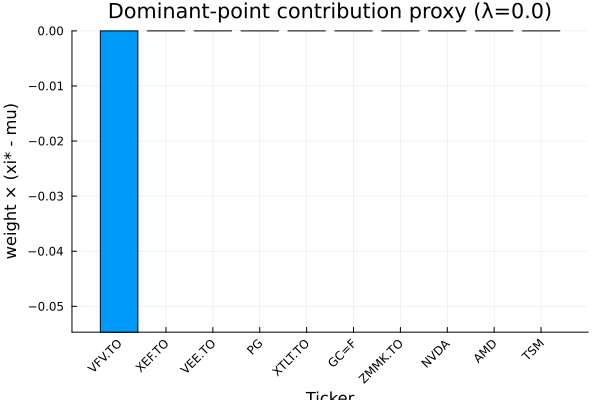

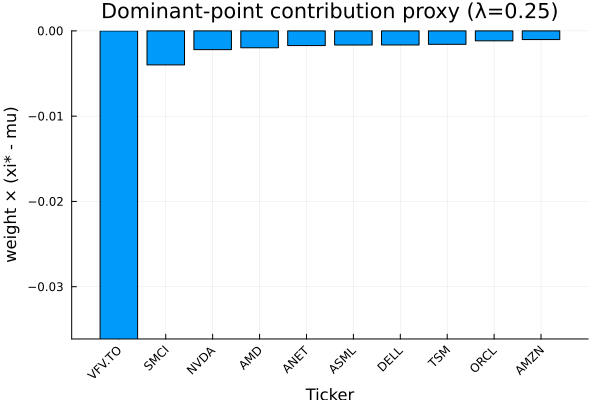

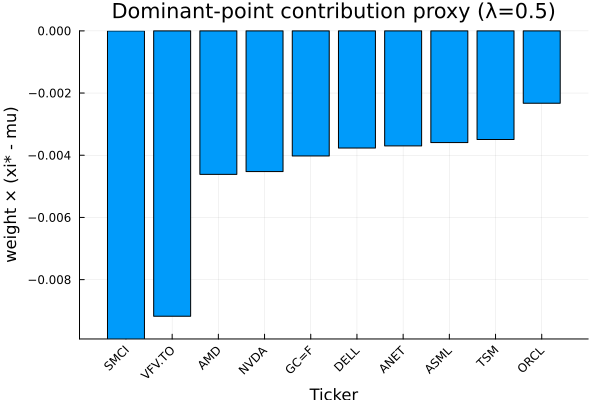

"C:\\Users\\Admin\\dominanting_point_lambda_0_5.png"

In [23]:
using Plots

function plot_top_contrib(report; k=12)
    df = report.top_contrib
    # keep k
    dfk = df[1:min(k, nrow(df)), :]
    p = bar(dfk.ticker, dfk.contrib,
            xlabel="Ticker",
            ylabel="weight × (xi* - mu)",
            title="Dominant-point contribution proxy (λ=$(report.λ))",
            legend=false, xrotation=45)
    return p
end

p1 = plot_top_contrib(reports[0.0])
p2 = plot_top_contrib(reports[0.25])
p3 = plot_top_contrib(reports[0.5])

display(p1); display(p2); display(p3)

# =========================================================
# 4) Save figures (optional)
# =========================================================
 savefig(p1, "dominanting_point_lambda_0.png")
 savefig(p2, "dominanting_point_lambda_0_25.png")
 savefig(p3,  "dominanting_point_lambda_0_5.png")


### 

In [18]:
# ==============================================================================
# POLICY RULES FOR SELECTING λ  (post-processing only)
# Inputs: tbl52_lambda (DataFrame), already computed for fixed L and alpha
# ==============================================================================

using DataFrames
using Statistics

df = sort(tbl52_lambda, :λ)

# ----------------------------
# Helper: pick max feasible λ
# ----------------------------
function max_feasible_lambda(df::DataFrame, cond::Function)
    feasible = df[cond.(eachrow(df)), :]
    if nrow(feasible) == 0
        return missing, feasible
    end
    # max λ among feasible
    idx = argmax(feasible.λ)
    return feasible.λ[idx], feasible
end

# =========================================================
# Rule A: Choose largest λ such that CVaR_MC <= cvar_cap
# =========================================================
function policy_rule_cvar(df::DataFrame; cvar_cap::Float64)
    λ_star, feasible = max_feasible_lambda(df, r -> r.CVaR_MC <= cvar_cap)
    return (
        rule = "CVaR cap",
        cvar_cap = cvar_cap,
        λ_star = λ_star,
        feasible_table = feasible
    )
end

# =========================================================
# Rule B: Choose largest λ such that P(loss>=L) <= beta
#   - can use MC or FORM (P1)
# =========================================================
function policy_rule_prob(df::DataFrame; beta::Float64, method::Symbol=:MC)
    if method == :MC
        cond = r -> r.MC <= beta
        label = "Prob cap (MC)"
    elseif method == :P1
        cond = r -> r.P1 <= beta
        label = "Prob cap (FORM)"
    else
        error("method must be :MC or :P1")
    end
    λ_star, feasible = max_feasible_lambda(df, cond)
    return (
        rule = label,
        beta = beta,
        λ_star = λ_star,
        feasible_table = feasible
    )
end

# =========================================================
# Rule C: Regime classification: Safe / Transition / Fragile
# Idea:
#   - Safe: comfortably below budgets (prob and CVaR)
#   - Transition: near budgets or accelerating tail severity
#   - Fragile: beyond budgets
# You can tune thresholds without re-running anything.
# =========================================================
function policy_rule_regimes(df::DataFrame;
                             beta_prob::Float64,
                             cvar_cap::Float64,
                             near_margin::Float64 = 0.10)  # 10% margin band
    out = deepcopy(df)

    # margins
    out.prob_ratio_mc = out.MC ./ beta_prob
    out.prob_ratio_p1 = out.P1 ./ beta_prob
    out.cvar_ratio    = out.CVaR_MC ./ cvar_cap

    # approximate "nonlinear acceleration" in CVaR via discrete slope
    slopes = [missing; diff(out.CVaR_MC) ./ diff(out.λ)]
    out.cvar_slope = slopes

    # define bands
    safe_cond(r) = (r.prob_ratio_mc <= (1 - near_margin)) && (r.cvar_ratio <= (1 - near_margin))
    fragile_cond(r) = (r.prob_ratio_mc > 1.0) || (r.cvar_ratio > 1.0)

    # transition = neither safe nor fragile
    regimes = Vector{String}(undef, nrow(out))
    for i in 1:nrow(out)
        r = out[i, :]
        if safe_cond(r)
            regimes[i] = "Safe"
        elseif fragile_cond(r)
            regimes[i] = "Fragile"
        else
            regimes[i] = "Transition"
        end
    end
    out.regime = regimes

    # λ* by regime boundary: largest Safe, and largest not-Fragile
    λ_safe, _ = max_feasible_lambda(out, r -> r.regime == "Safe")
    λ_not_fragile, _ = max_feasible_lambda(out, r -> r.regime != "Fragile")

    return (
        rule = "Regime classification",
        beta_prob = beta_prob,
        cvar_cap = cvar_cap,
        near_margin = near_margin,
        λ_safe_max = λ_safe,
        λ_not_fragile_max = λ_not_fragile,
        table = out
    )
end

# ==============================================================================
# RUN ALL 3 EXAMPLES (tune caps to your liking)
# ==============================================================================
# You can set caps based on what you consider acceptable.
# Example choices:
# - beta_prob: allow at most 0.8% weekly probability of loss >= L (beta=0.008)
# - cvar_cap: cap ES around 5.6% weekly (0.056)
beta_prob = 0.008
cvar_cap  = 0.056

resA = policy_rule_cvar(df; cvar_cap=cvar_cap)
resB_mc = policy_rule_prob(df; beta=beta_prob, method=:MC)
resB_p1 = policy_rule_prob(df; beta=beta_prob, method=:P1)
resC = policy_rule_regimes(df; beta_prob=beta_prob, cvar_cap=cvar_cap, near_margin=0.10)

println("=======================================")
println("Policy Rule A (CVaR cap): cvar_cap = ", cvar_cap, " => λ* = ", resA.λ_star)
println("Policy Rule B (Prob cap, MC): beta = ", beta_prob, " => λ* = ", resB_mc.λ_star)
println("Policy Rule B (Prob cap, FORM): beta = ", beta_prob, " => λ* = ", resB_p1.λ_star)
println("Policy Rule C (Regimes):")
println("  max Safe λ = ", resC.λ_safe_max)
println("  max non-Fragile λ = ", resC.λ_not_fragile_max)
println("=======================================")

# Optional: display tables
display(resA.feasible_table)
display(resB_mc.feasible_table)
display(resC.table)

# Optional: export final regime table
CSV.write("policy_regimes_table.csv", resC.table)


Policy Rule A (CVaR cap): cvar_cap = 0.056 => λ* = 0.35
Policy Rule B (Prob cap, MC): beta = 0.008 => λ* = 0.3
Policy Rule B (Prob cap, FORM): beta = 0.008 => λ* = 0.3
Policy Rule C (Regimes):
  max Safe λ = 0.1
  max non-Fragile λ = 0.3


Row,λ,L,P1,MC,hits,MC_lo,MC_hi,VaR_MC,CVaR_MC,t,I
,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.05,0.00406617,0.00363,726,0.00337579,0.00390327,0.0427416,0.0496501,2.68298,3.59919
2,0.05,0.05,0.00409185,0.003875,775,0.00361208,0.00415698,0.0428264,0.0498842,2.68092,3.59366
3,0.1,0.05,0.0043178,0.003955,791,0.00368929,0.00423976,0.0430402,0.0501759,2.66327,3.54652
4,0.15,0.05,0.00475712,0.004405,881,0.00412413,0.00470491,0.0436277,0.0510025,2.63124,3.46172
5,0.2,0.05,0.0054366,0.00489,978,0.00459365,0.00520537,0.04451,0.0516746,2.58662,3.34531
6,0.25,0.05,0.00639475,0.005765,1153,0.00544256,0.00610643,0.0455787,0.0528834,2.5316,3.20449
7,0.3,0.05,0.00767903,0.007175,1435,0.00681445,0.00755448,0.0470477,0.0549688,2.46849,3.04672
8,0.35,0.05,0.00934241,0.00818,1636,0.00779458,0.00858431,0.048275,0.0559647,2.39957,2.87896


Row,λ,L,P1,MC,hits,MC_lo,MC_hi,VaR_MC,CVaR_MC,t,I
,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.05,0.00406617,0.00363,726,0.00337579,0.00390327,0.0427416,0.0496501,2.68298,3.59919
2,0.05,0.05,0.00409185,0.003875,775,0.00361208,0.00415698,0.0428264,0.0498842,2.68092,3.59366
3,0.1,0.05,0.0043178,0.003955,791,0.00368929,0.00423976,0.0430402,0.0501759,2.66327,3.54652
4,0.15,0.05,0.00475712,0.004405,881,0.00412413,0.00470491,0.0436277,0.0510025,2.63124,3.46172
5,0.2,0.05,0.0054366,0.00489,978,0.00459365,0.00520537,0.04451,0.0516746,2.58662,3.34531
6,0.25,0.05,0.00639475,0.005765,1153,0.00544256,0.00610643,0.0455787,0.0528834,2.5316,3.20449
7,0.3,0.05,0.00767903,0.007175,1435,0.00681445,0.00755448,0.0470477,0.0549688,2.46849,3.04672


Row,λ,L,P1,MC,hits,MC_lo,MC_hi,VaR_MC,CVaR_MC,t,I,prob_ratio_mc,prob_ratio_p1,cvar_ratio,cvar_slope,regime
,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,String
1,0.0,0.05,0.00406617,0.00363,726,0.00337579,0.00390327,0.0427416,0.0496501,2.68298,3.59919,0.45375,0.508271,0.886608,missing,Safe
2,0.05,0.05,0.00409185,0.003875,775,0.00361208,0.00415698,0.0428264,0.0498842,2.68092,3.59366,0.484375,0.511482,0.89079,0.00468338,Safe
3,0.1,0.05,0.0043178,0.003955,791,0.00368929,0.00423976,0.0430402,0.0501759,2.66327,3.54652,0.494375,0.539725,0.895999,0.00583374,Safe
4,0.15,0.05,0.00475712,0.004405,881,0.00412413,0.00470491,0.0436277,0.0510025,2.63124,3.46172,0.550625,0.594639,0.91076,0.0165325,Transition
5,0.2,0.05,0.0054366,0.00489,978,0.00459365,0.00520537,0.04451,0.0516746,2.58662,3.34531,0.61125,0.679575,0.92276,0.0134408,Transition
6,0.25,0.05,0.00639475,0.005765,1153,0.00544256,0.00610643,0.0455787,0.0528834,2.5316,3.20449,0.720625,0.799343,0.944347,0.0241767,Transition
7,0.3,0.05,0.00767903,0.007175,1435,0.00681445,0.00755448,0.0470477,0.0549688,2.46849,3.04672,0.896875,0.959879,0.981586,0.0417081,Transition
8,0.35,0.05,0.00934241,0.00818,1636,0.00779458,0.00858431,0.048275,0.0559647,2.39957,2.87896,1.0225,1.1678,0.99937,0.0199176,Fragile
9,0.4,0.05,0.00999992,0.008815,1763,0.00841467,0.0092342,0.0488319,0.056869,2.37533,2.8211,1.10187,1.24999,1.01552,0.0180869,Fragile


"policy_regimes_table.csv"

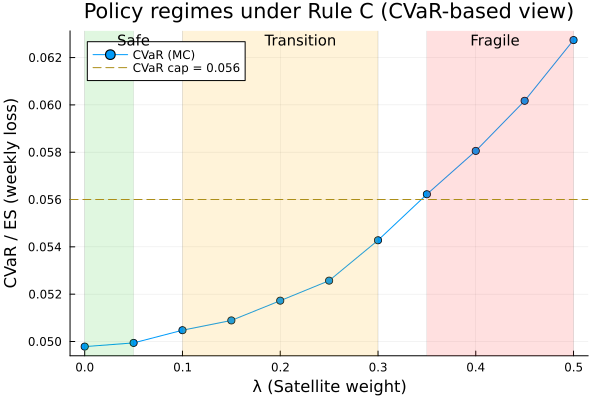

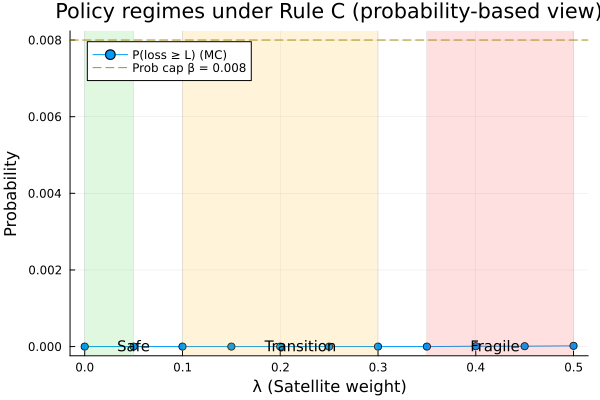

"C:\\Users\\Admin\\policy_regimes_prob.png"

In [24]:
using Plots
using DataFrames

# Input tables from your policy rule C
dfR = sort(resC.table, :λ)

λ = dfR.λ
cvar = dfR.CVaR_MC
prob = dfR.MC

beta_prob = resC.beta_prob
cvar_cap  = resC.cvar_cap

# --- helper: get contiguous λ-intervals for each regime ---
function regime_intervals(df::DataFrame; col_regime::Symbol=:regime, col_x::Symbol=:λ)
    xs = df[!, col_x]
    regs = df[!, col_regime]

    intervals = Dict{String, Vector{Tuple{Float64,Float64}}}()
    for r in unique(regs)
        intervals[string(r)] = Tuple{Float64,Float64}[]
    end

    n = length(xs)
    i = 1
    while i <= n
        r = string(regs[i])
        xL = xs[i]
        j = i
        while j < n && regs[j+1] == regs[i]
            j += 1
        end
        xR = xs[j]
        push!(intervals[r], (Float64(xL), Float64(xR)))
        i = j + 1
    end
    return intervals
end

intervals = regime_intervals(dfR)

# --- colors (soft) ---
# You can change alpha (transparency) if you want stronger shading.
col_safe = RGBA(0.2, 0.8, 0.2, 0.15)
col_trans = RGBA(1.0, 0.7, 0.0, 0.15)
col_frag = RGBA(1.0, 0.2, 0.2, 0.15)

function add_regime_bands!(p, intervals)
    if haskey(intervals, "Safe")
        for (a,b) in intervals["Safe"]
            vspan!(p, [a,b], color=col_safe, label=false)
        end
    end
    if haskey(intervals, "Transition")
        for (a,b) in intervals["Transition"]
            vspan!(p, [a,b], color=col_trans, label=false)
        end
    end
    if haskey(intervals, "Fragile")
        for (a,b) in intervals["Fragile"]
            vspan!(p, [a,b], color=col_frag, label=false)
        end
    end
    return p
end

# =========================================================
# FIGURE 1: CVaR vs λ with regime shading + cap line
# =========================================================
p_cvar = plot(
    λ, cvar,
    marker=:circle,
    label="CVaR (MC)",
    xlabel="λ (Satellite weight)",
    ylabel="CVaR / ES (weekly loss)",
    title="Policy regimes under Rule C (CVaR-based view)",
    legend=:topleft
)

add_regime_bands!(p_cvar, intervals)

hline!(p_cvar, [cvar_cap], linestyle=:dash, label="CVaR cap = $(cvar_cap)")

# add text labels in the middle of bands (optional)
annotate!(p_cvar, (0.05, maximum(cvar), text("Safe", 10)))
annotate!(p_cvar, (0.22, maximum(cvar), text("Transition", 10)))
annotate!(p_cvar, (0.42, maximum(cvar), text("Fragile", 10)))

display(p_cvar)

# =========================================================
# FIGURE 2 (optional): MC probability vs λ with shading + beta line
# =========================================================
p_prob = plot(
    λ, prob,
    marker=:circle,
    label="P(loss ≥ L) (MC)",
    xlabel="λ (Satellite weight)",
    ylabel="Probability",
    title="Policy regimes under Rule C (probability-based view)",
    legend=:topleft
)

add_regime_bands!(p_prob, intervals)

hline!(p_prob, [beta_prob], linestyle=:dash, label="Prob cap β = $(beta_prob)")

annotate!(p_prob, (0.05, maximum(prob), text("Safe", 10)))
annotate!(p_prob, (0.22, maximum(prob), text("Transition", 10)))
annotate!(p_prob, (0.42, maximum(prob), text("Fragile", 10)))

display(p_prob)

# Optional save
 savefig(p_cvar, "policy_regimes_cvar.png")
 savefig(p_prob, "policy_regimes_prob.png")



Running sensitivity for L = 0.05


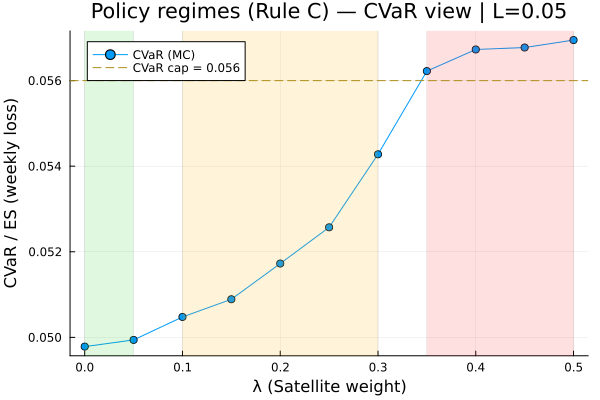

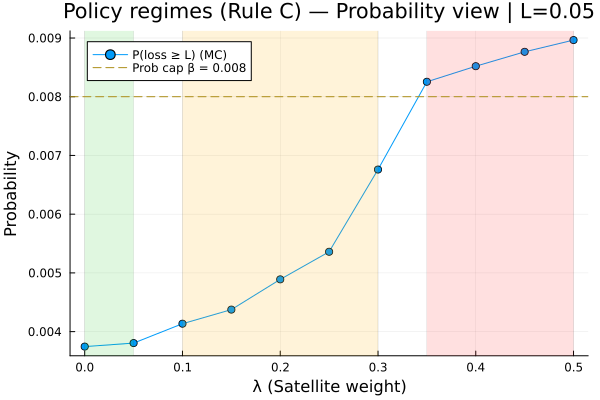


Running sensitivity for L = 0.08


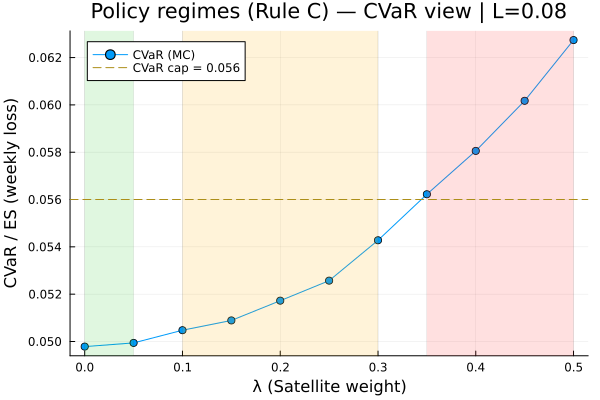

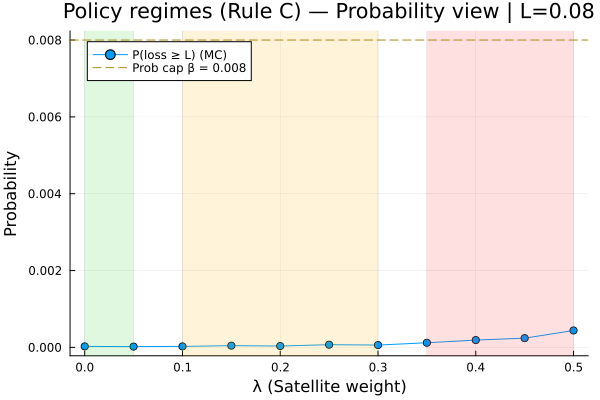


Running sensitivity for L = 0.1


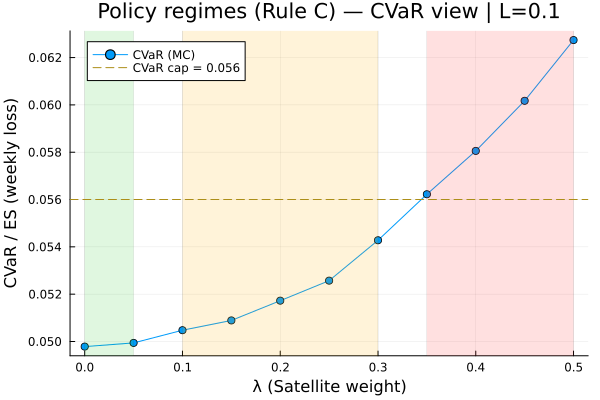

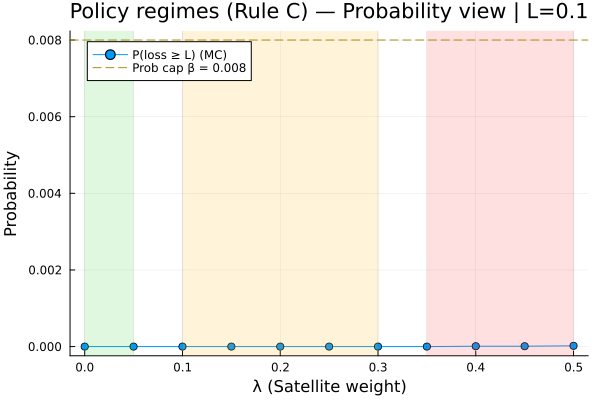


SUMMARY TABLE OF POLICY OUTPUTS


Row,L,lambda_star_CVaR,lambda_star_prob_MC,lambda_star_prob_FORM,lambda_safe_max,lambda_not_fragile_max
,Float64,Any,Any,Any,Any,Any
1,0.05,0.3,0.3,0.3,0.05,0.3
2,0.08,0.3,0.5,0.5,0.05,0.3
3,0.1,0.3,0.5,0.5,0.05,0.3


In [25]:
# ==============================================================================
# SENSITIVITY ANALYSIS OVER L (loss threshold)
# Runs full lambda-grid + policies + regime figures for multiple L values.
# ==============================================================================

using DataFrames
using Plots
using Statistics

# -----------------------------
# Assumes these are already in memory from your notebook:
# μ, Σ_all (joint, order tickers_all = [satellite; core])
# μC, μS, ΣCC, ΣSS, ΣCS
# tickers_all, tickers_sat
# and you already defined:
#   run_lambda_grid_results(...)
#   policy_rule_cvar(...)
#   policy_rule_prob(...)
#   policy_rule_regimes(...)
#   regime_intervals(...)
#   add_regime_bands!(...)
# -----------------------------

# Satellite weights (keep same as before: equal-weight)
wS = fill(1/length(tickers_sat), length(tickers_sat))

# Policy budgets (keep same as before for comparability)
beta_prob = 0.008
cvar_cap  = 0.056

# Sensitivity settings
L_list = [0.05, 0.08, 0.10]
lambdas = 0.0:0.05:0.50
alpha = 0.01

# MC size (adjust if needed)
Nmc = 200_000
seed = 1234

# Store results
all_tables = Dict{Float64, DataFrame}()
all_policies = DataFrame(
    L = Float64[],
    lambda_star_CVaR = Any[],
    lambda_star_prob_MC = Any[],
    lambda_star_prob_FORM = Any[],
    lambda_safe_max = Any[],
    lambda_not_fragile_max = Any[]
)

# --------- helpers for figures (reuse your previous functions) ----------
# If not already defined in your notebook, re-define them here:

function regime_intervals(df::DataFrame; col_regime::Symbol=:regime, col_x::Symbol=:λ)
    xs = df[!, col_x]
    regs = df[!, col_regime]

    intervals = Dict{String, Vector{Tuple{Float64,Float64}}}()
    for r in unique(regs)
        intervals[string(r)] = Tuple{Float64,Float64}[]
    end

    n = length(xs)
    i = 1
    while i <= n
        r = string(regs[i])
        xL = xs[i]
        j = i
        while j < n && regs[j+1] == regs[i]
            j += 1
        end
        xR = xs[j]
        push!(intervals[r], (Float64(xL), Float64(xR)))
        i = j + 1
    end
    return intervals
end

col_safe = RGBA(0.2, 0.8, 0.2, 0.15)
col_trans = RGBA(1.0, 0.7, 0.0, 0.15)
col_frag = RGBA(1.0, 0.2, 0.2, 0.15)

function add_regime_bands!(p, intervals)
    if haskey(intervals, "Safe")
        for (a,b) in intervals["Safe"]
            vspan!(p, [a,b], color=col_safe, label=false)
        end
    end
    if haskey(intervals, "Transition")
        for (a,b) in intervals["Transition"]
            vspan!(p, [a,b], color=col_trans, label=false)
        end
    end
    if haskey(intervals, "Fragile")
        for (a,b) in intervals["Fragile"]
            vspan!(p, [a,b], color=col_frag, label=false)
        end
    end
    return p
end

# =============================
# MAIN LOOP OVER L
# =============================
for L in L_list
    println("\n==============================")
    println("Running sensitivity for L = ", L)
    println("==============================")

    # 1) Recompute lambda grid table at this L
    tbl, core_w_byλ, full_w_byλ = run_lambda_grid_results(
        μ, Σ_all, μC, μS, ΣCC, ΣSS, ΣCS, wS;
        lambdas=lambdas,
        alpha=alpha,
        L=L,
        Nmc=Nmc,
        seed=seed
    )
    tbl = sort(tbl, :λ)
    all_tables[L] = tbl

    # 2) Policies A/B/C
    resA = policy_rule_cvar(tbl; cvar_cap=cvar_cap)
    resB_mc = policy_rule_prob(tbl; beta=beta_prob, method=:MC)
    resB_p1 = policy_rule_prob(tbl; beta=beta_prob, method=:P1)
    resC = policy_rule_regimes(tbl; beta_prob=beta_prob, cvar_cap=cvar_cap, near_margin=0.10)

    push!(all_policies, (
        Float64(L),
        resA.λ_star,
        resB_mc.λ_star,
        resB_p1.λ_star,
        resC.λ_safe_max,
        resC.λ_not_fragile_max
    ))

    # 3) Regime figures
    dfR = sort(resC.table, :λ)
    intervals = regime_intervals(dfR)

    # CVaR view
    p_cvar = plot(
        dfR.λ, dfR.CVaR_MC,
        marker=:circle,
        label="CVaR (MC)",
        xlabel="λ (Satellite weight)",
        ylabel="CVaR / ES (weekly loss)",
        title="Policy regimes (Rule C) — CVaR view | L=$(L)",
        legend=:topleft
    )
    add_regime_bands!(p_cvar, intervals)
    hline!(p_cvar, [cvar_cap], linestyle=:dash, label="CVaR cap = $(cvar_cap)")
    display(p_cvar)

    # Prob view
    p_prob = plot(
        dfR.λ, dfR.MC,
        marker=:circle,
        label="P(loss ≥ L) (MC)",
        xlabel="λ (Satellite weight)",
        ylabel="Probability",
        title="Policy regimes (Rule C) — Probability view | L=$(L)",
        legend=:topleft
    )
    add_regime_bands!(p_prob, intervals)
    hline!(p_prob, [beta_prob], linestyle=:dash, label="Prob cap β = $(beta_prob)")
    display(p_prob)

    # Optional save
    savefig(p_cvar, "regimes_cvar_L$(round(Int,100L)).png")
    savefig(p_prob, "regimes_prob_L$(round(Int,100L)).png")
end

println("\n==============================")
println("SUMMARY TABLE OF POLICY OUTPUTS")
println("==============================")
display(all_policies)
